# Import Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-Processing Data

In [ ]:
# Tentukan direktori dataset tambahkan Augmentasi (Flip = Horizontal)
import os
import numpy as np
import cv2

def load_data(data_dir):
    images = []
    masks = []
    filenames = []  # Array untuk menyimpan nama file

    for filename in os.listdir(os.path.join(data_dir, 'images')):
        if filename.endswith(('.jpeg','.jpg', '.png')):
            img = cv2.imread(os.path.join(data_dir, 'images', filename))
            img = cv2.resize(img, (256, 256))
            images.append(img)

            mask = cv2.imread(os.path.join(data_dir, 'masks', filename), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (256, 256))
            mask = np.stack([mask, 255 - mask], axis=-1)  # one-hot encoding
            masks.append(mask)

            # Simpan nama file
            filenames.append(filename)

    return np.array(images), np.array(masks), filenames  # Mengembalikan array nama file juga


In [ ]:
# Tentukan direktori dataset
import os
import numpy as np
import cv2
data_dir = '/content/drive/MyDrive/TREK-AI'

# Baca dataset
X, y, filenames = load_data(data_dir)

# Modifikasi rasio
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1
random_state = 42

In [ ]:
len(X)

913

In [ ]:
from sklearn.model_selection import train_test_split
# Bagi data menjadi data latih, data validasi, dan data uji
X_train, X_temp, y_train, y_temp, filenames_train, filenames_temp = train_test_split(
    X, y, filenames, test_size=1 - train_ratio, random_state=random_state, shuffle=True, stratify=None
)

X_val, X_test, y_val, y_test, filenames_val, filenames_test = train_test_split(
    X_temp, y_temp, filenames_temp, test_size=test_ratio / (test_ratio + validation_ratio),
    random_state=random_state, shuffle=True, stratify=None
)
print(len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), len(y_test))


730 91 92 730 91 92


In [ ]:
len(filenames_train)

730

In [ ]:
len(filenames_val)

91

In [ ]:
len(filenames_test)

92

In [ ]:
#Testing data
#X_test_real, y_test_real, filenames_test = load_data('/content/drive/MyDrive/TREK-AI/test')

In [ ]:
#X_test_n = X_test_real.astype('float32') / 255.0
#y_test_n = y_test_real.astype('float32') / 255.0

In [ ]:
# Normalize
y_train_conf = y_train.astype('float32') / 255.0  # Konversi ke float32 dan normalisasi
y_val_conf = y_val.astype('float32') / 255.0

# Pastikan data masukan (X_train dan X_val) telah dinormalisasi ke rentang [0, 1]
X_train_conf = X_train.astype('float32') / 255.0
X_val_conf = X_val.astype('float32') / 255.0

X_test_c = X_test.astype('float32') / 255.0
y_test_c = y_test.astype('float32') / 255.0

#Training

In [ ]:
!pip install --upgrade segmentation-models
!pip install segmentation-models-pytorch
!pip install torch
!pip install -U segmentation-models

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

import segmentation_models as sm

from segmentation_models import Unet

from segmentation_models import FPN

import segmentation_models_pytorch as smp

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import torch

import matplotlib.pyplot as plt
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from tensorflow.keras.callbacks import Callback

Segmentation Models: using `tf.keras` framework.


### Unet

Unet - ResNet50

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_Unet_ResNet50 = Unet('resnet50', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_Unet_ResNet50 with additional metrics
model_Unet_ResNet50.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_Unet_ResNet50 = model_Unet_ResNet50.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


Epoch 1/100
46/46 [==============================] - 47s 434ms/step - loss: 0.6471 - iou_score: 0.6162 - dice_coefficient: 0.8002 - accuracy: 0.9461 - val_loss: 56.7276 - val_iou_score: 0.0891 - val_dice_coefficient: 0.1738 - val_accuracy: 0.1711
Epoch 2/100
46/46 [==============================] - 18s 391ms/step - loss: 0.1845 - iou_score: 0.8785 - dice_coefficient: 0.9539 - accuracy: 0.9898 - val_loss: 1.0567 - val_iou_score: 0.4126 - val_dice_coefficient: 0.7730 - val_accuracy: 0.8385
Epoch 3/100
46/46 [==============================] - 18s 396ms/step - loss: 0.0984 - iou_score: 0.9372 - dice_coefficient: 0.9783 - accuracy: 0.9922 - val_loss: 1.1512 - val_iou_score: 0.4170 - val_dice_coefficient: 0.8141 - val_accuracy: 0.8385
Epoch 4/100
46/46 [==============================] - 18s 391ms/step - loss: 0.0684 - iou_score: 0.9566 - dice_coefficient: 0.9856 - accuracy: 0.9944 - val_loss: 4.7744 - val_iou_score: 0.2870 - val_dice_coefficient: 0.4528 - val_accuracy: 0.4571
Epoch 5/100
46/

In [ ]:
model_Unet_ResNet50.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 15s 4s/step - loss: 0.0437 - iou_score: 0.9744 - dice_coefficient: 0.9926 - accuracy: 0.9956


[0.043729886412620544,
 0.974423348903656,
 0.9926353096961975,
 0.9956457614898682]

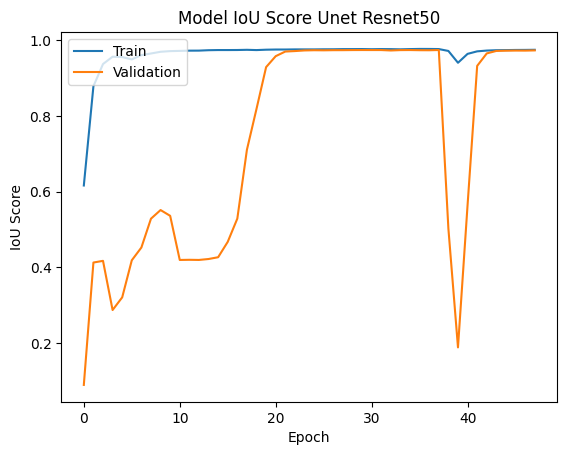

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_Unet_ResNet50.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_ResNet50.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score Unet Resnet50')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


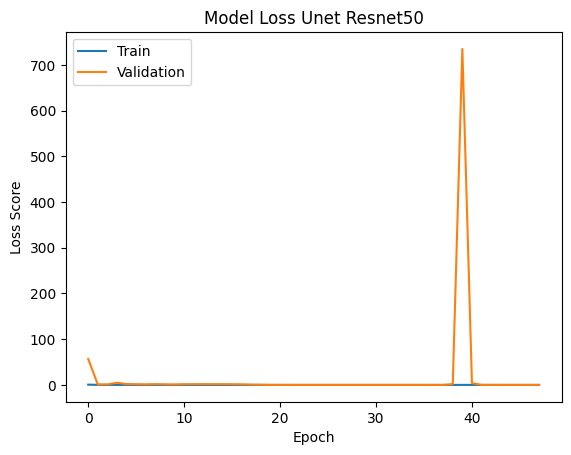

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_Unet_ResNet50.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_ResNet50.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss Unet Resnet50')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_Unet_ResNet50.save("/content/drive/MyDrive/TREK-AI/Model_Save/Unet-ResNet50.h5")

Unet - InceptionV3

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_Unet_Inceptionv3 = Unet('inceptionv3', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_Unet_Inceptionv3 with additional metrics
model_Unet_Inceptionv3.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_Unet_Inceptionv3 = model_Unet_Inceptionv3.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


Epoch 1/100
46/46 [==============================] - 124s 957ms/step - loss: 0.5431 - iou_score: 0.6873 - dice_coefficient: 0.8095 - accuracy: 0.9544 - val_loss: 45.9426 - val_iou_score: 0.3142 - val_dice_coefficient: 0.4840 - val_accuracy: 0.5902
Epoch 2/100
46/46 [==============================] - 16s 355ms/step - loss: 0.1095 - iou_score: 0.9316 - dice_coefficient: 0.9682 - accuracy: 0.9943 - val_loss: 0.5342 - val_iou_score: 0.7180 - val_dice_coefficient: 0.8686 - val_accuracy: 0.9335
Epoch 3/100
46/46 [==============================] - 17s 361ms/step - loss: 0.0685 - iou_score: 0.9577 - dice_coefficient: 0.9833 - accuracy: 0.9950 - val_loss: 0.1232 - val_iou_score: 0.9243 - val_dice_coefficient: 0.9701 - val_accuracy: 0.9913
Epoch 4/100
46/46 [==============================] - 17s 364ms/step - loss: 0.0566 - iou_score: 0.9651 - dice_coefficient: 0.9874 - accuracy: 0.9953 - val_loss: 0.0670 - val_iou_score: 0.9581 - val_dice_coefficient: 0.9845 - val_accuracy: 0.9949
Epoch 5/100
46

In [ ]:
model_Unet_Inceptionv3.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 26s 6s/step - loss: 0.0425 - iou_score: 0.9753 - dice_coefficient: 0.9929 - accuracy: 0.9959


[0.042474571615457535,
 0.9753238558769226,
 0.9929178357124329,
 0.9959055185317993]

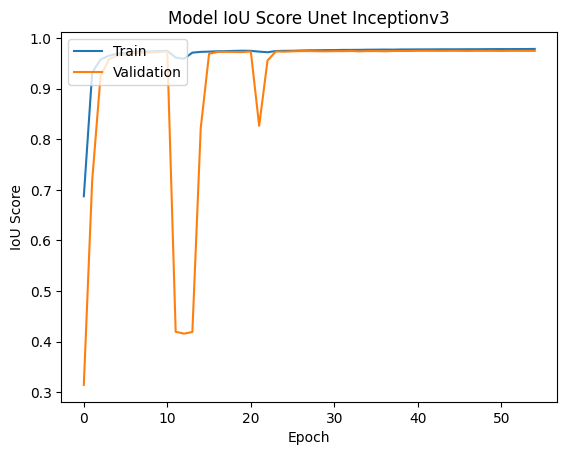

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_Unet_Inceptionv3.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_Inceptionv3.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score Unet Inceptionv3')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


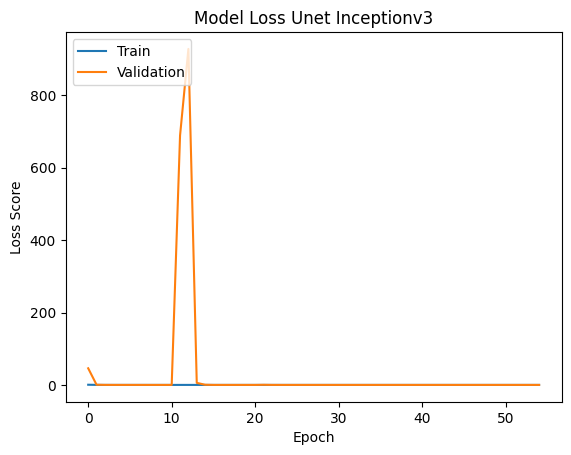

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_Unet_Inceptionv3.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_Inceptionv3.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss Unet Inceptionv3')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_Unet_Inceptionv3.save("/content/drive/MyDrive/TREK-AI/Model_Save/Unet-Inceptionv3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Unet - DenseNet121

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_Unet_DenseNet121 = Unet('densenet121', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_Unet_DenseNet121 with additional metrics
model_Unet_DenseNet121.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_Unet_DenseNet121 = model_Unet_DenseNet121.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


Epoch 1/100
46/46 [==============================] - 120s 803ms/step - loss: 0.4987 - iou_score: 0.6927 - dice_coefficient: 0.8527 - accuracy: 0.9659 - val_loss: 0.4000 - val_iou_score: 0.7568 - val_dice_coefficient: 0.9194 - val_accuracy: 0.9480
Epoch 2/100
46/46 [==============================] - 17s 372ms/step - loss: 0.1047 - iou_score: 0.9310 - dice_coefficient: 0.9762 - accuracy: 0.9924 - val_loss: 0.6790 - val_iou_score: 0.6297 - val_dice_coefficient: 0.8772 - val_accuracy: 0.9049
Epoch 3/100
46/46 [==============================] - 17s 376ms/step - loss: 0.0654 - iou_score: 0.9582 - dice_coefficient: 0.9864 - accuracy: 0.9945 - val_loss: 0.1412 - val_iou_score: 0.9162 - val_dice_coefficient: 0.9728 - val_accuracy: 0.9846
Epoch 4/100
46/46 [==============================] - 17s 377ms/step - loss: 0.0542 - iou_score: 0.9658 - dice_coefficient: 0.9892 - accuracy: 0.9952 - val_loss: 0.0783 - val_iou_score: 0.9522 - val_dice_coefficient: 0.9851 - val_accuracy: 0.9922
Epoch 5/100
46/

In [ ]:
model_Unet_DenseNet121.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 15s 4s/step - loss: 0.0444 - iou_score: 0.9732 - dice_coefficient: 0.9922 - accuracy: 0.9956


[0.04444639012217522,
 0.9732361435890198,
 0.9922071099281311,
 0.9956389665603638]

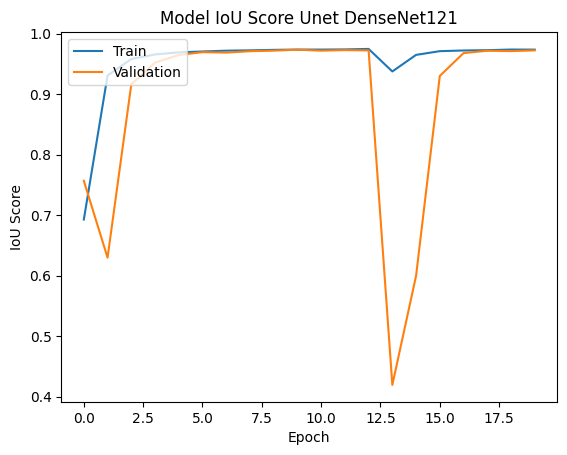

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_Unet_DenseNet121.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_DenseNet121.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score Unet DenseNet121')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


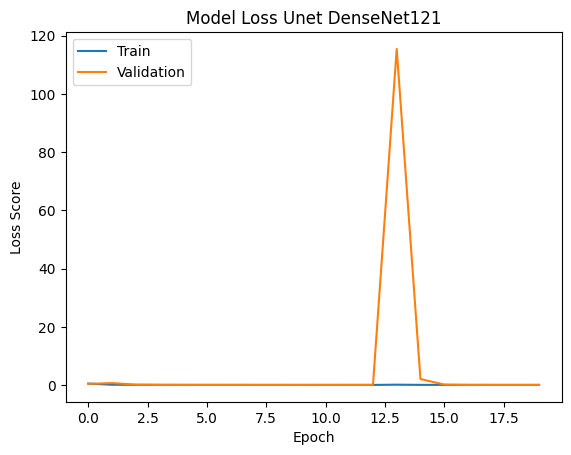

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_Unet_DenseNet121.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_DenseNet121.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss Unet DenseNet121')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
# Arahkan ke direktori yang kalian inginkan
model_Unet_DenseNet121.save("/content/drive/MyDrive/TREK-AI/Model_Save/Unet-DenseNet121.h5")

Unet - DenseNet169

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_Unet_DenseNet169 = Unet('densenet169', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_Unet_DenseNet169 with additional metrics
model_Unet_DenseNet169.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_Unet_DenseNet169 = model_Unet_DenseNet169.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


51877672/51877672 [==============================] - 3s 0us/step
Epoch 1/100
46/46 [==============================] - 135s 725ms/step - loss: 0.5635 - iou_score: 0.6558 - dice_coefficient: 0.8361 - accuracy: 0.9575 - val_loss: 2.7814 - val_iou_score: 0.6179 - val_dice_coefficient: 0.8269 - val_accuracy: 0.8678
Epoch 2/100
46/46 [==============================] - 21s 454ms/step - loss: 0.1484 - iou_score: 0.8964 - dice_coefficient: 0.9680 - accuracy: 0.9921 - val_loss: 0.4570 - val_iou_score: 0.7360 - val_dice_coefficient: 0.9123 - val_accuracy: 0.9435
Epoch 3/100
46/46 [==============================] - 20s 443ms/step - loss: 0.0934 - iou_score: 0.9393 - dice_coefficient: 0.9815 - accuracy: 0.9921 - val_loss: 1.0878 - val_iou_score: 0.4995 - val_dice_coefficient: 0.8464 - val_accuracy: 0.8605
Epoch 4/100
46/46 [==============================] - 20s 435ms/step - loss: 0.0643 - iou_score: 0.9583 - dice_coefficient: 0.9874 - accuracy: 0.9945 - val_loss: 0.1071 - val_iou_score: 0.9331 - va

In [ ]:
model_Unet_DenseNet169.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 7s 2s/step - loss: 0.0426 - iou_score: 0.9745 - dice_coefficient: 0.9927 - accuracy: 0.9958


[0.042630501091480255,
 0.9744968414306641,
 0.9927082061767578,
 0.9958033561706543]

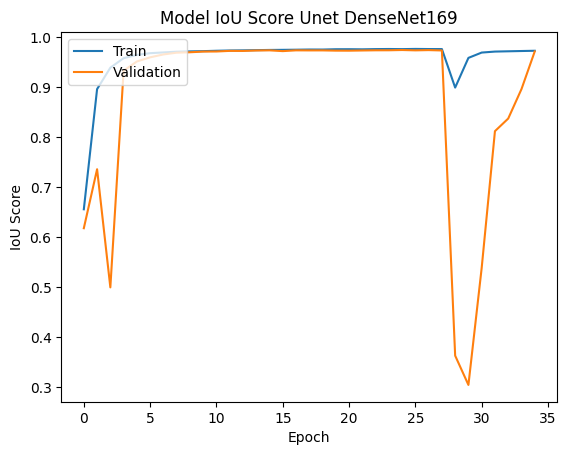

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_Unet_DenseNet169.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_DenseNet169.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score Unet DenseNet169')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


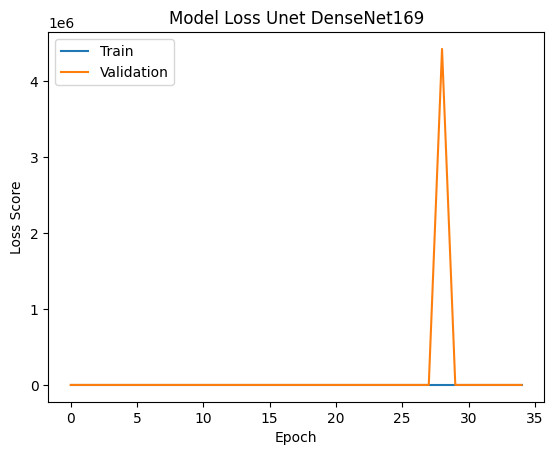

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_Unet_DenseNet169.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_Unet_DenseNet169.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss Unet DenseNet169')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
# Arahkan ke direktori yang kalian inginkan
model_Unet_DenseNet169.save("/content/drive/MyDrive/TREK-AI/Model_Save/Unet-DenseNet169.h5")

### FPN

FPN - ResNet18

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_FPN_ResNet18 = FPN('resnet18', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_FPN_ResNet18 with additional metrics
model_FPN_ResNet18.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_FPN_ResNet18 = model_FPN_ResNet18.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


44920640/44920640 [==============================] - 0s 0us/step
Epoch 1/100
46/46 [==============================] - 48s 599ms/step - loss: 0.2672 - iou_score: 0.8460 - dice_coefficient: 0.9358 - accuracy: 0.9532 - val_loss: 1.1977 - val_iou_score: 0.4154 - val_dice_coefficient: 0.8142 - val_accuracy: 0.8385
Epoch 2/100
46/46 [==============================] - 24s 515ms/step - loss: 0.0650 - iou_score: 0.9598 - dice_coefficient: 0.9880 - accuracy: 0.9919 - val_loss: 1.5459 - val_iou_score: 0.4188 - val_dice_coefficient: 0.8362 - val_accuracy: 0.8385
Epoch 3/100
46/46 [==============================] - 23s 509ms/step - loss: 0.0514 - iou_score: 0.9684 - dice_coefficient: 0.9907 - accuracy: 0.9941 - val_loss: 1.7639 - val_iou_score: 0.4191 - val_dice_coefficient: 0.8381 - val_accuracy: 0.8385
Epoch 4/100
46/46 [==============================] - 23s 508ms/step - loss: 0.0466 - iou_score: 0.9713 - dice_coefficient: 0.9916 - accuracy: 0.9949 - val_loss: 1.7383 - val_iou_score: 0.4192 - val

In [ ]:
model_FPN_ResNet18.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 2s 621ms/step - loss: 0.0440 - iou_score: 0.9755 - dice_coefficient: 0.9930 - accuracy: 0.9957


[0.043966107070446014,
 0.9754522442817688,
 0.9930254817008972,
 0.9956721663475037]

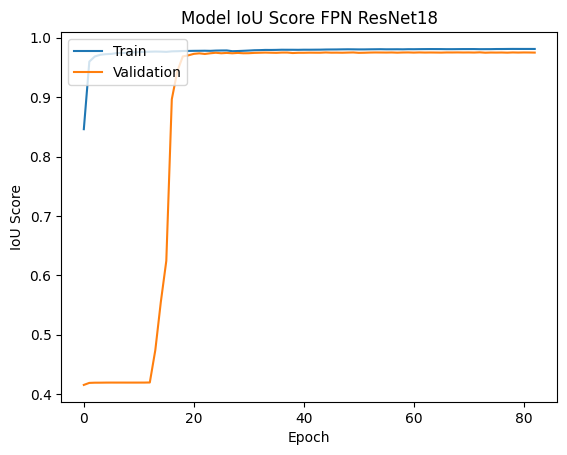

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_FPN_ResNet18.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_ResNet18.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score FPN ResNet18')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

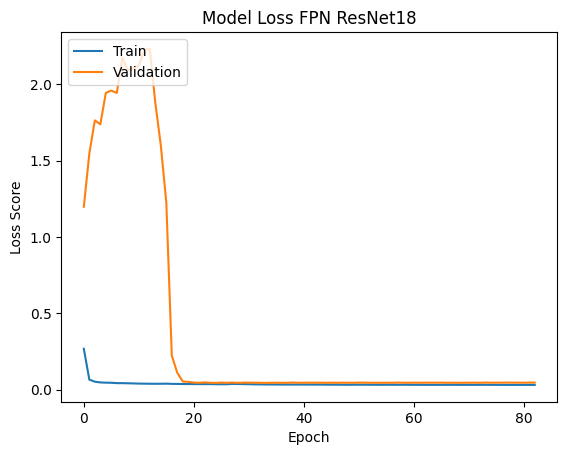

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_FPN_ResNet18.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_ResNet18.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss FPN ResNet18')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_FPN_ResNet18.save("/content/drive/MyDrive/TREK-AI/Model_Save/FPN-ResNet18.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


FPN-ResNet50

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_FPN_ResNet50 = FPN('resnet50', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_FPN_ResNet50 with additional metrics
model_FPN_ResNet50.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_FPN_ResNet50 = model_FPN_ResNet50.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


Epoch 1/100
46/46 [==============================] - 63s 666ms/step - loss: 0.2830 - iou_score: 0.8408 - dice_coefficient: 0.9346 - accuracy: 0.9528 - val_loss: 1.6508 - val_iou_score: 0.4188 - val_dice_coefficient: 0.8360 - val_accuracy: 0.8385
Epoch 2/100
46/46 [==============================] - 29s 635ms/step - loss: 0.0770 - iou_score: 0.9521 - dice_coefficient: 0.9858 - accuracy: 0.9898 - val_loss: 1.9356 - val_iou_score: 0.4189 - val_dice_coefficient: 0.8378 - val_accuracy: 0.8385
Epoch 3/100
46/46 [==============================] - 30s 643ms/step - loss: 0.0552 - iou_score: 0.9660 - dice_coefficient: 0.9901 - accuracy: 0.9934 - val_loss: 1.6940 - val_iou_score: 0.4193 - val_dice_coefficient: 0.8380 - val_accuracy: 0.8385
Epoch 4/100
46/46 [==============================] - 30s 648ms/step - loss: 0.0507 - iou_score: 0.9689 - dice_coefficient: 0.9909 - accuracy: 0.9941 - val_loss: 1.8812 - val_iou_score: 0.4193 - val_dice_coefficient: 0.8384 - val_accuracy: 0.8385
Epoch 5/100
46/4

In [ ]:
# Evaluate model_FPN_ResNet50 on test data
model_FPN_ResNet50.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 1s 356ms/step - loss: 0.0449 - iou_score: 0.9741 - dice_coefficient: 0.9926 - accuracy: 0.9955


[0.04492800682783127,
 0.9740714430809021,
 0.9925959706306458,
 0.9954598546028137]

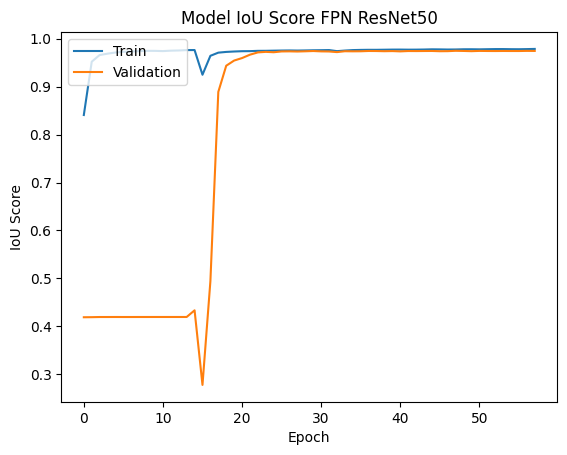

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_FPN_ResNet50.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_ResNet50.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score FPN ResNet50')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


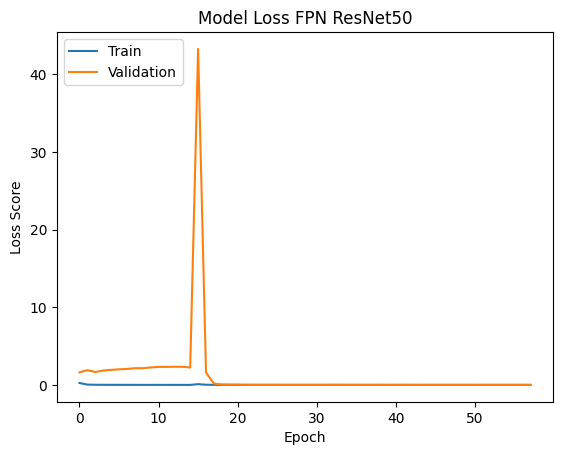

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_FPN_ResNet50.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_ResNet50.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss FPN ResNet50')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_FPN_ResNet50.save("/content/drive/MyDrive/TREK-AI/Model_Save/FPN-ResNet50.h5")

FPN - DenseNet121

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_FPN_DenseNet121 = FPN('densenet121', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_FPN_DenseNet121 with additional metrics
model_FPN_DenseNet121.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_FPN_DenseNet121 = model_FPN_DenseNet121.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
46/46 [==============================] - 103s 755ms/step - loss: 0.2521 - iou_score: 0.8584 - dice_coefficient: 0.9384 - accuracy: 0.9553 - val_loss: 0.7859 - val_iou_score: 0.6487 - val_dice_coefficient: 0.8762 - val_accuracy: 0.8997
Epoch 2/100
46/46 [==============================] - 29s 628ms/step - loss: 0.0583 - iou_score: 0.9639 - dice_coefficient: 0.9892 - accuracy: 0.9930 - val_loss: 0.1538 - val_iou_score: 0.9252 - val_dice_coefficient: 0.9775 - val_accuracy: 0.9821
Epoch 3/100
46/46 [==============================] - 30s 643ms/step - loss: 0.0515 - iou_score: 0.9682 - dice_coefficient: 0.9906 - accuracy: 0.9940 - val_loss: 0.0762 - val_iou_score: 0.9554 - val_dice_coefficient: 0.9869 - val_accuracy: 0.9907
Epoch 4/100
46/46 [==============================] - 30s 662ms/step - loss: 0.0453 - iou_score: 0.9721 - dice_coefficient: 0.9918 - accuracy: 0.9952 - val_loss: 0.0520 - val_iou_score: 0.9676 - va

In [ ]:
# Evaluate model_FPN_DenseNet121 on test data
model_FPN_DenseNet121.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 3s 821ms/step - loss: 0.0422 - iou_score: 0.9750 - dice_coefficient: 0.9928 - accuracy: 0.9958


[0.04215873405337334, 0.974973201751709, 0.992838442325592, 0.9957622289657593]

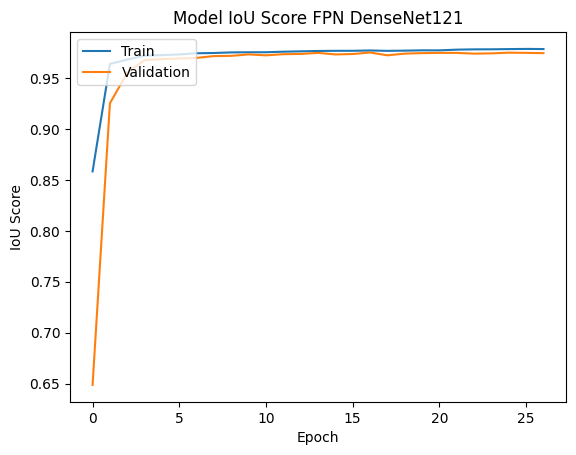

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_FPN_DenseNet121.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_DenseNet121.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score FPN DenseNet121')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


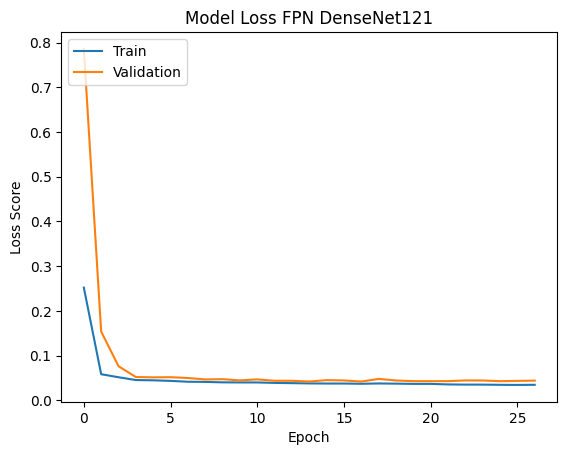

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_FPN_DenseNet121.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_DenseNet121.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss FPN DenseNet121')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_FPN_DenseNet121.save("/content/drive/MyDrive/TREK-AI/Model_Save/FPN-DenseNet121.h5")

FPN - DenseNet169

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_FPN_DenseNet169 = FPN('densenet169', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_FPN_DenseNet169 with additional metrics
model_FPN_DenseNet169.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_FPN_DenseNet169 = model_FPN_DenseNet169.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


Epoch 1/100
46/46 [==============================] - 231s 2s/step - loss: 0.2460 - iou_score: 0.8615 - dice_coefficient: 0.9415 - accuracy: 0.9557 - val_loss: 1.2907 - val_iou_score: 0.6952 - val_dice_coefficient: 0.9108 - val_accuracy: 0.9133
Epoch 2/100
46/46 [==============================] - 33s 720ms/step - loss: 0.0586 - iou_score: 0.9637 - dice_coefficient: 0.9893 - accuracy: 0.9929 - val_loss: 0.2815 - val_iou_score: 0.8723 - val_dice_coefficient: 0.9635 - val_accuracy: 0.9686
Epoch 3/100
46/46 [==============================] - 33s 713ms/step - loss: 0.0486 - iou_score: 0.9699 - dice_coefficient: 0.9912 - accuracy: 0.9945 - val_loss: 0.0646 - val_iou_score: 0.9609 - val_dice_coefficient: 0.9887 - val_accuracy: 0.9929
Epoch 4/100
46/46 [==============================] - 33s 711ms/step - loss: 0.0465 - iou_score: 0.9714 - dice_coefficient: 0.9917 - accuracy: 0.9949 - val_loss: 0.0540 - val_iou_score: 0.9672 - val_dice_coefficient: 0.9905 - val_accuracy: 0.9938
Epoch 5/100
46/46 

In [ ]:
# Evaluate model_FPN_DenseNet201 on test data
model_FPN_DenseNet169.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 51s 12s/step - loss: 0.0434 - iou_score: 0.9751 - dice_coefficient: 0.9929 - accuracy: 0.9956


[0.043364521116018295,
 0.9750871658325195,
 0.9929027557373047,
 0.99555903673172]

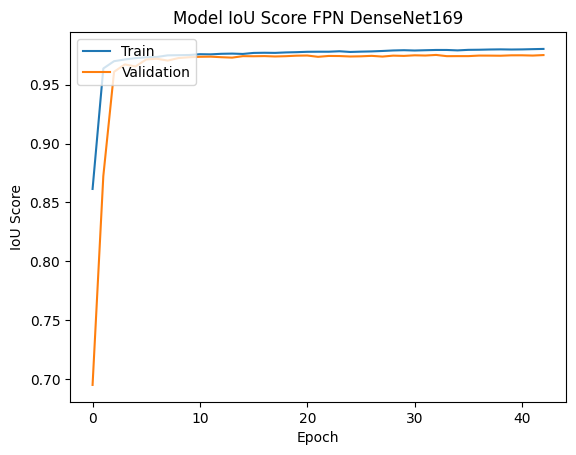

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_FPN_DenseNet169.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_DenseNet169.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score FPN DenseNet169')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


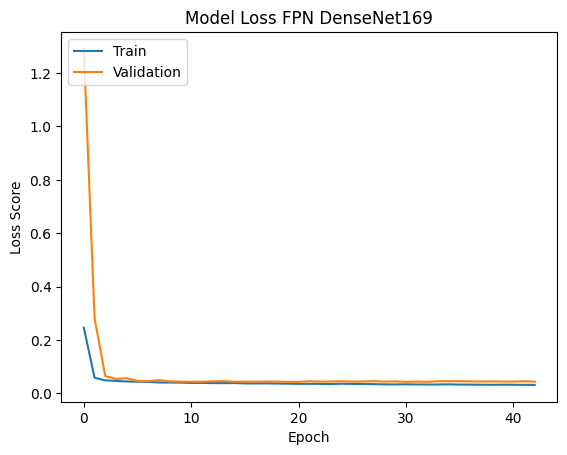

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_FPN_DenseNet169.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_DenseNet169.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss FPN DenseNet169')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_FPN_DenseNet169.save("/content/drive/MyDrive/TREK-AI/Model_Save/FPN-DenseNet169.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


FPN - DenseNet201

In [ ]:
import tensorflow as tf

# Load or define your model (replace 'Unet' with the actual module/class name)
model_FPN_DenseNet201 = FPN('densenet201', classes=2, activation='sigmoid', input_shape=(256, 256, 3))

# Define custom metrics functions if needed (e.g., dice coefficient)
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection) / (union + tf.keras.backend.epsilon())

# Additional metrics for compilation
metrics = [iou_score, dice_coefficient, 'accuracy']

# Compile model_FPN_DenseNet201 with additional metrics
model_FPN_DenseNet201.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=metrics)

# Modify the callback to include additional metrics
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Train the model without data augmentation
history_FPN_DenseNet201 = model_FPN_DenseNet201.fit(
    X_train_conf,  # Assuming X_train_conf and y_train_conf are your training data
    y_train_conf,
    batch_size=16,
    epochs=100,
    validation_data=(X_val_conf, y_val_conf),
    callbacks=callbacks
)


74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/100
46/46 [==============================] - 257s 2s/step - loss: 0.2470 - iou_score: 0.8595 - dice_coefficient: 0.9404 - accuracy: 0.9571 - val_loss: 1.1120 - val_iou_score: 0.6642 - val_dice_coefficient: 0.8615 - val_accuracy: 0.8803
Epoch 2/100
46/46 [==============================] - 36s 781ms/step - loss: 0.0573 - iou_score: 0.9644 - dice_coefficient: 0.9894 - accuracy: 0.9931 - val_loss: 0.2248 - val_iou_score: 0.8859 - val_dice_coefficient: 0.9665 - val_accuracy: 0.9720
Epoch 3/100
46/46 [==============================] - 36s 780ms/step - loss: 0.0488 - iou_score: 0.9699 - dice_coefficient: 0.9911 - accuracy: 0.9945 - val_loss: 0.0847 - val_iou_score: 0.9529 - val_dice_coefficient: 0.9861 - val_accuracy: 0.9893
Epoch 4/100
46/46 [==============================] - 36s 778ms/step - loss: 0.0484 - iou_score: 0.9703 - dice_coefficient: 0.9913 - accuracy: 0.9946 - val_loss: 0.0560 - val_iou_score: 0.9662 - val_d

In [ ]:
# Evaluate model_FPN_DenseNet201 on test data
model_FPN_DenseNet201.evaluate(X_test_c, y_test_c)

3/3 [==============================] - 53s 13s/step - loss: 0.0437 - iou_score: 0.9745 - dice_coefficient: 0.9927 - accuracy: 0.9956


[0.04365675523877144,
 0.9745151400566101,
 0.9927024841308594,
 0.9956205487251282]

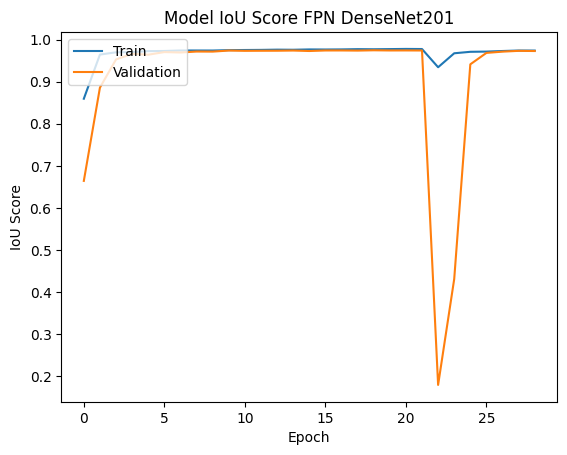

In [ ]:
# Plot IoU scores over epochs
plt.plot(history_FPN_DenseNet201.history['iou_score'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_DenseNet201.history['val_iou_score'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model IoU Score FPN DenseNet201')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


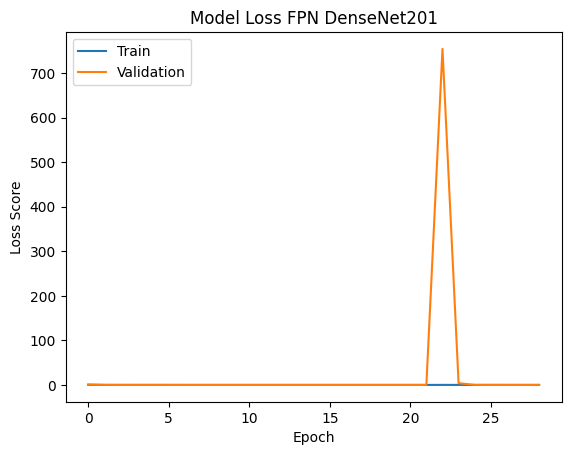

In [ ]:
# Plot Loss scores over epochs
plt.plot(history_FPN_DenseNet201.history['loss'])  # Use 'iou_score' instead of 'iou_score'
plt.plot(history_FPN_DenseNet201.history['val_loss'])  # Use 'val_iou_score' instead of 'val_iou_score'
plt.title('Model Loss FPN DenseNet201')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Save model
model_FPN_DenseNet201.save("/content/drive/MyDrive/TREK-AI/Model_Save/FPN-DenseNet201.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Predict Model

Data Train

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Image

# Load the model
model_path = '/content/drive/MyDrive/TREK-AI/model_save/FPN-ResNet18.h5'
model = load_model(model_path, compile=False)

# Assume X_train is your input data and filesname_train is a list of corresponding file names
# Here, X_train should be a NumPy array with shape (num_samples, height, width, channels)
# For example, if X_train is a list of images, you can convert it to a NumPy array like this:
# X_train = np.array(X_train)

# Specify the folder path to save the binary masks
output_folder = '/content/drive/MyDrive/TREK-AI/BinaryMasks/train_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through each example in X_train
for i, filename in enumerate(filenames_train):
    # Normalize the image to values between 0 and 1
    normalized_image = X_train[i] / 255.0

    # Add batch dimension
    input_data = np.expand_dims(normalized_image, axis=0)

    # Make predictions
    predictions = model.predict(input_data)

    # If the output from the model is probabilities, convert to a binary mask
    binary_mask = (predictions > 0.5).astype(np.uint8)

    # Save the binary mask as an image file in the specified folder
    # Save the binary mask as an image file in the specified folder
    image_filename = f'{filename}'
    cv2.imwrite(os.path.join(output_folder, image_filename), binary_mask[0, :, :, 0] * 255)



1/1 [==============================] - 0s 20ms/step


Data Val

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Image

# Load the model
model_path = '/content/drive/MyDrive/TREK-AI/model_save/FPN-ResNet18.h5'
model = load_model(model_path, compile=False)

# Assume X_train is your input data and filesname_train is a list of corresponding file names
# Here, X_train should be a NumPy array with shape (num_samples, height, width, channels)
# For example, if X_train is a list of images, you can convert it to a NumPy array like this:
# X_train = np.array(X_train)

# Specify the folder path to save the binary masks
output_folder = '/content/drive/MyDrive/TREK-AI/BinaryMasks/val_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through each example in X_val
for i, filename in enumerate(filenames_val):
    # Normalize the image to values between 0 and 1
    normalized_image = X_val[i] / 255.0

    # Add batch dimension
    input_data = np.expand_dims(normalized_image, axis=0)

    # Make predictions
    predictions = model.predict(input_data)

    # If the output from the model is probabilities, convert to a binary mask
    binary_mask = (predictions > 0.5).astype(np.uint8)

    # Save the binary mask as an image file in the specified folder
    # Save the binary mask as an image file in the specified folder
    image_filename = f'{filename}'
    cv2.imwrite(os.path.join(output_folder, image_filename), binary_mask[0, :, :, 0] * 255)



1/1 [==============================] - 0s 21ms/step


Data Test

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Image

# Load the model
model_path = '/content/drive/MyDrive/TREK-AI/model_save/FPN-ResNet18.h5'
model = load_model(model_path, compile=False)

# Assume X_train is your input data and filesname_train is a list of corresponding file names
# Here, X_train should be a NumPy array with shape (num_samples, height, width, channels)
# For example, if X_train is a list of images, you can convert it to a NumPy array like this:
# X_train = np.array(X_train)

# Specify the folder path to save the binary masks
output_folder = '/content/drive/MyDrive/TREK-AI/BinaryMasks/test_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through each example in X_val
for i, filename in enumerate(filenames_test):
    # Normalize the image to values between 0 and 1
    normalized_image = X_test[i] / 255.0

    # Add batch dimension
    input_data = np.expand_dims(normalized_image, axis=0)

    # Make predictions
    predictions = model.predict(input_data)

    # If the output from the model is probabilities, convert to a binary mask
    binary_mask = (predictions > 0.5).astype(np.uint8)

    # Save the binary mask as an image file in the specified folder
    # Save the binary mask as an image file in the specified folder
    image_filename = f'{filename}'
    cv2.imwrite(os.path.join(output_folder, image_filename), binary_mask[0, :, :, 0] * 255)



1/1 [==============================] - 0s 21ms/step
